The `make_cuped_tweedie_26` data generating process (DGP) creates a synthetic dataset characterized by a Tweedie-like outcome (zero-inflated with a heavy right tail), correlated confounders, and structured heterogeneous treatment effects (HTE). It also includes a pre-period covariate (`y_pre`) calibrated for CUPED benchmarks.


### 1. Confounders ($X$)
Five confounders are generated using a Gaussian Copula to induce specific correlations:
- `tenure_months` ($X_1$): $\text{Lognormal}(\mu=2.5, \sigma=0.5)$
- `avg_sessions_week` ($X_2$): $\text{NegativeBinomial}(\mu=5, \alpha=0.5)$
- `spend_last_month` ($X_3$): $\text{Lognormal}(\mu=4.0, \sigma=0.8)$
- `discount_rate` ($X_4$): $\text{Beta}(\text{mean}=0.1, \kappa=20)$
- `platform` ($X_5$): Categorical with levels `android` (65%), `ios` (30%), `web` (5%).

**Correlations:** $\text{corr}(X_1, X_2) = 0.4$ and $\text{corr}(X_2, X_3) = 0.5$.


### 2. Treatment Assignment ($D$)
The treatment $D$ is assigned via a Bernoulli trial with a constant propensity score (RCT):
$$D \sim \text{Bernoulli}(0.5)$$
*(Note: While the generator supports complex propensity models, `make_cuped_tweedie_26` defaults to a balanced random assignment).*


### 3. Outcome Model ($Y$)
The outcome is generated as a two-part (hurdle) process:
$$Y = I \cdot Y_{pos}$$

#### A. Binary Indicator of Non-zero Outcome ($I$)
$$I \sim \text{Bernoulli}(\sigma(\alpha_{zi} + \text{u\_strength}_{zi} \cdot U))$$
- $\sigma(z) = \frac{1}{1 + e^{-z}}$ is the sigmoid function.
- $\alpha_{zi} = 0.0$ (resulting in ~50% baseline non-zero rate).
- $\text{u\_strength}_{zi} = 1.0$ (if `add_pre=True`).
- $U \sim \mathcal{N}(0, 1)$ is an unobserved confounder.

#### B. Positive Outcome Value ($Y_{pos}$)
If $I=1$, the value is drawn from a Gamma distribution:
$$Y_{pos} \sim \text{Gamma}(\text{shape}=k, \text{scale}=\mu_{pos} / k)$$
- $k = 2.0$ (shape parameter).
- $\mu_{pos} = \exp(\text{loc})$, where $\text{loc}$ is the linear predictor on the log-mean scale:
  $$\text{loc} = \alpha_y + D \cdot \tau(X) + \text{u\_strength}_y \cdot U$$
- $\alpha_y = 2.0$.
- $\text{u\_strength}_y = 1.0$ (if `add_pre=True`).


### 4. Heterogeneous Treatment Effect ($\tau(X)$)
The treatment effect $\tau(X)$ is defined on the log-mean scale and incorporates monotone effects, diminishing returns, and categorical modifiers:
$$\tau(X) = \text{clip}\left(\theta_{log} \cdot g_t(X_1) \cdot g_s(X_2) \cdot \text{seg}(X_5), 0, 2.5 \cdot \theta_{log}\right)$$
Where:
- $g_t(X_1) = \frac{1}{1 + \exp(-0.25 \cdot (X_1 - 12))}$ (Saturating effect of tenure).
- $g_s(X_2) = \frac{1}{1 + \exp(-0.35 \cdot (X_2 - 4))}$ (Diminishing returns of sessions).
- $\text{seg}(X_5) = 1 + 0.3 \cdot \mathbb{1}_{\text{platform}=\text{ios}}$ (Premium segment modifier).
- $\theta_{log} = 0.12$ (Default log-uplift parameter).


### 5. Pre-period Covariate ($y_{pre}$)
The pre-period covariate is generated using the same two-part structure as the outcome but replaces the unobserved confounder $U$ with a shared latent driver $A \sim \mathcal{N}(0, 1)$:
$$y_{pre} = (I_{pre} \cdot Y_{pos, pre}) + \sigma_{noise} \cdot \epsilon$$
- $\epsilon \sim \mathcal{N}(0, 1)$.
- The influence of the shared driver $A$ and the noise scale $\sigma_{noise}$ are calibrated (via numerical optimization) to ensure $y_{pre}$ achieves a target correlation (default $0.6$) with the post-period outcome $Y$ in the control group.

In [1]:

from causalis.scenarios.cuped.dgp import make_cuped_tweedie_26
from causalis.data_contracts import CausalData

data = make_cuped_tweedie_26(return_causal_data=False, include_oracle=True)
data.head()


,y,d,tenure_months,avg_sessions_week,spend_last_month,discount_rate,platform_ios,platform_web,m,m_obs,tau_link,g0,g1,cate,y_pre
0,0.000000,0.0,14.187461,2.0,57.355300,0.158164,0.0,0.0,0.5,0.5,0.042035,3.694528,3.853136,0.158608,0.000000
1,0.000000,1.0,6.352893,3.0,46.700946,0.085722,0.0,0.0,0.5,0.5,0.016201,3.694528,3.754870,0.060342,0.000000
2,12.918910,0.0,18.910153,9.0,80.136187,0.175115,1.0,0.0,0.5,0.5,0.188082,3.694528,4.459044,0.764516,219.374863
3,13.079312,1.0,7.927627,4.0,33.718224,0.152718,0.0,0.0,0.5,0.5,0.026540,3.694528,3.793893,0.099365,0.000000
4,0.000000,0.0,11.106925,2.0,92.064518,0.077390,0.0,0.0,0.5,0.5,0.029492,3.694528,3.805111,0.110583,0.000000


In [2]:
print(f'Ground truth ATE is {data['cate'].mean()}')
print(f'Ground truth ATTE is {data[data['d'] == 1]['cate'].mean()}')

Ground truth ATE is 0.2700720823988466
Ground truth ATTE is 0.27094666120202526


In [3]:
causaldata = CausalData(df = data,
                        treatment='d',
                        outcome='y',
                        confounders=['tenure_months', 'avg_sessions_week', 'spend_last_month', 'discount_rate', 'platform_ios', 'platform_web', 'y_pre'])
causaldata

CausalData(df=(100000, 9), treatment='d', outcome='y', confounders=['tenure_months', 'avg_sessions_week', 'spend_last_month', 'discount_rate', 'platform_ios', 'platform_web', 'y_pre'])

In [4]:
from causalis.shared import outcome_stats
outcome_stats(causaldata)

,treatment,count,mean,std,min,p10,p25,median,p75,p90,max
0,0.0,49868,8.496830,20.907555,0.0,0.0,0.0,0.0,8.903005,23.685134,637.127367
1,1.0,50132,9.056301,21.790102,0.0,0.0,0.0,0.0,9.523496,25.207978,764.333725


In [5]:
from causalis.shared import confounders_balance

confounders_balance(causaldata)

,confounders,mean_d_0,mean_d_1,abs_diff,smd,ks_pvalue
0,platform_web,0.051356,0.048312,0.003043,-0.013985,0.97420
1,y_pre,15420.530166,51673.005274,36252.475108,0.008842,0.22562
2,tenure_months,13.756301,13.794400,0.038099,0.005198,0.56587
3,platform_ios,0.300032,0.301444,0.001412,0.003079,1.00000
4,avg_sessions_week,4.995969,5.003610,0.007641,0.001816,0.88605
5,spend_last_month,75.176560,75.263792,0.087232,0.001222,0.22678
6,discount_rate,0.100197,0.100129,0.000068,-0.001031,0.64488


In [7]:
from causalis.shared import outcome_plot_dist, outcome_plot_boxplot

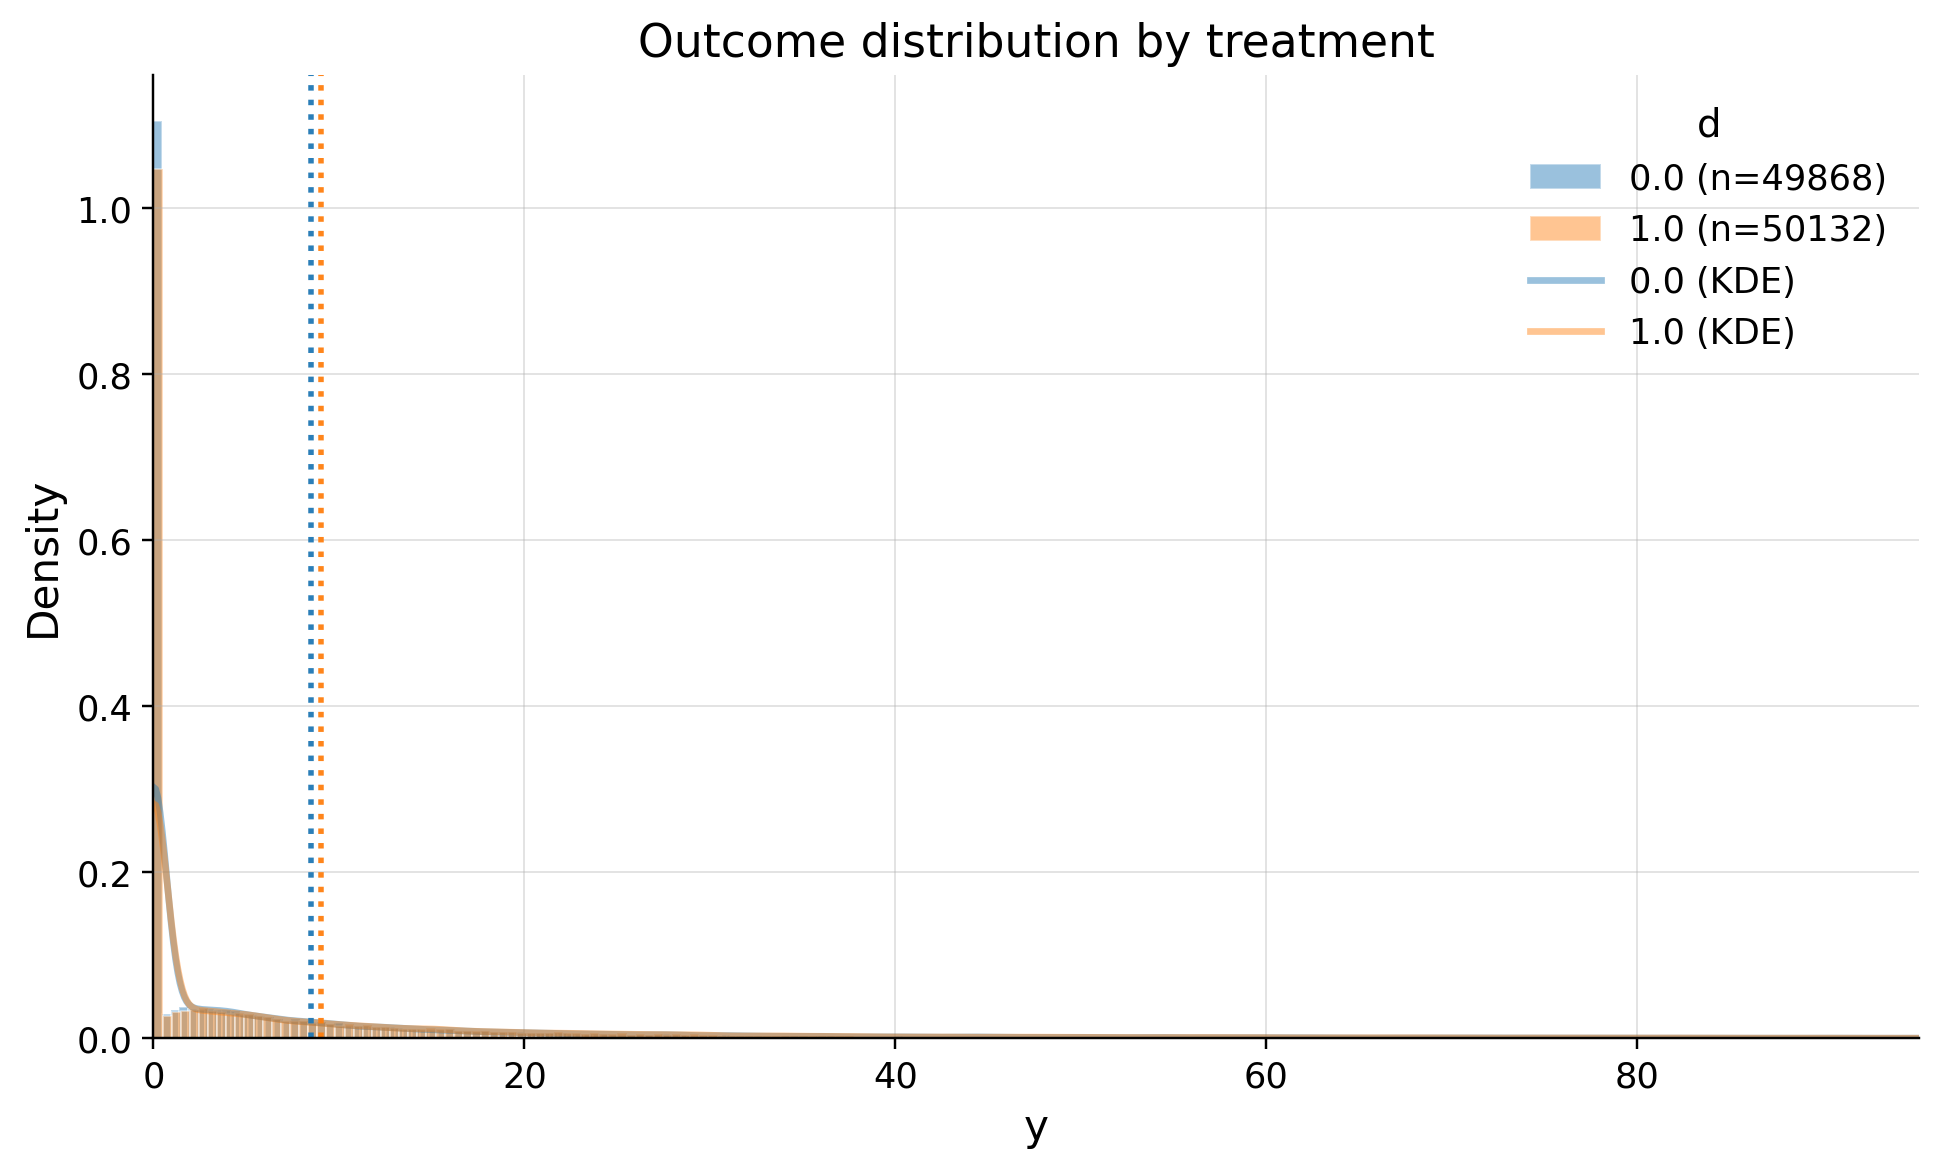

In [8]:
outcome_plot_dist(causaldata)

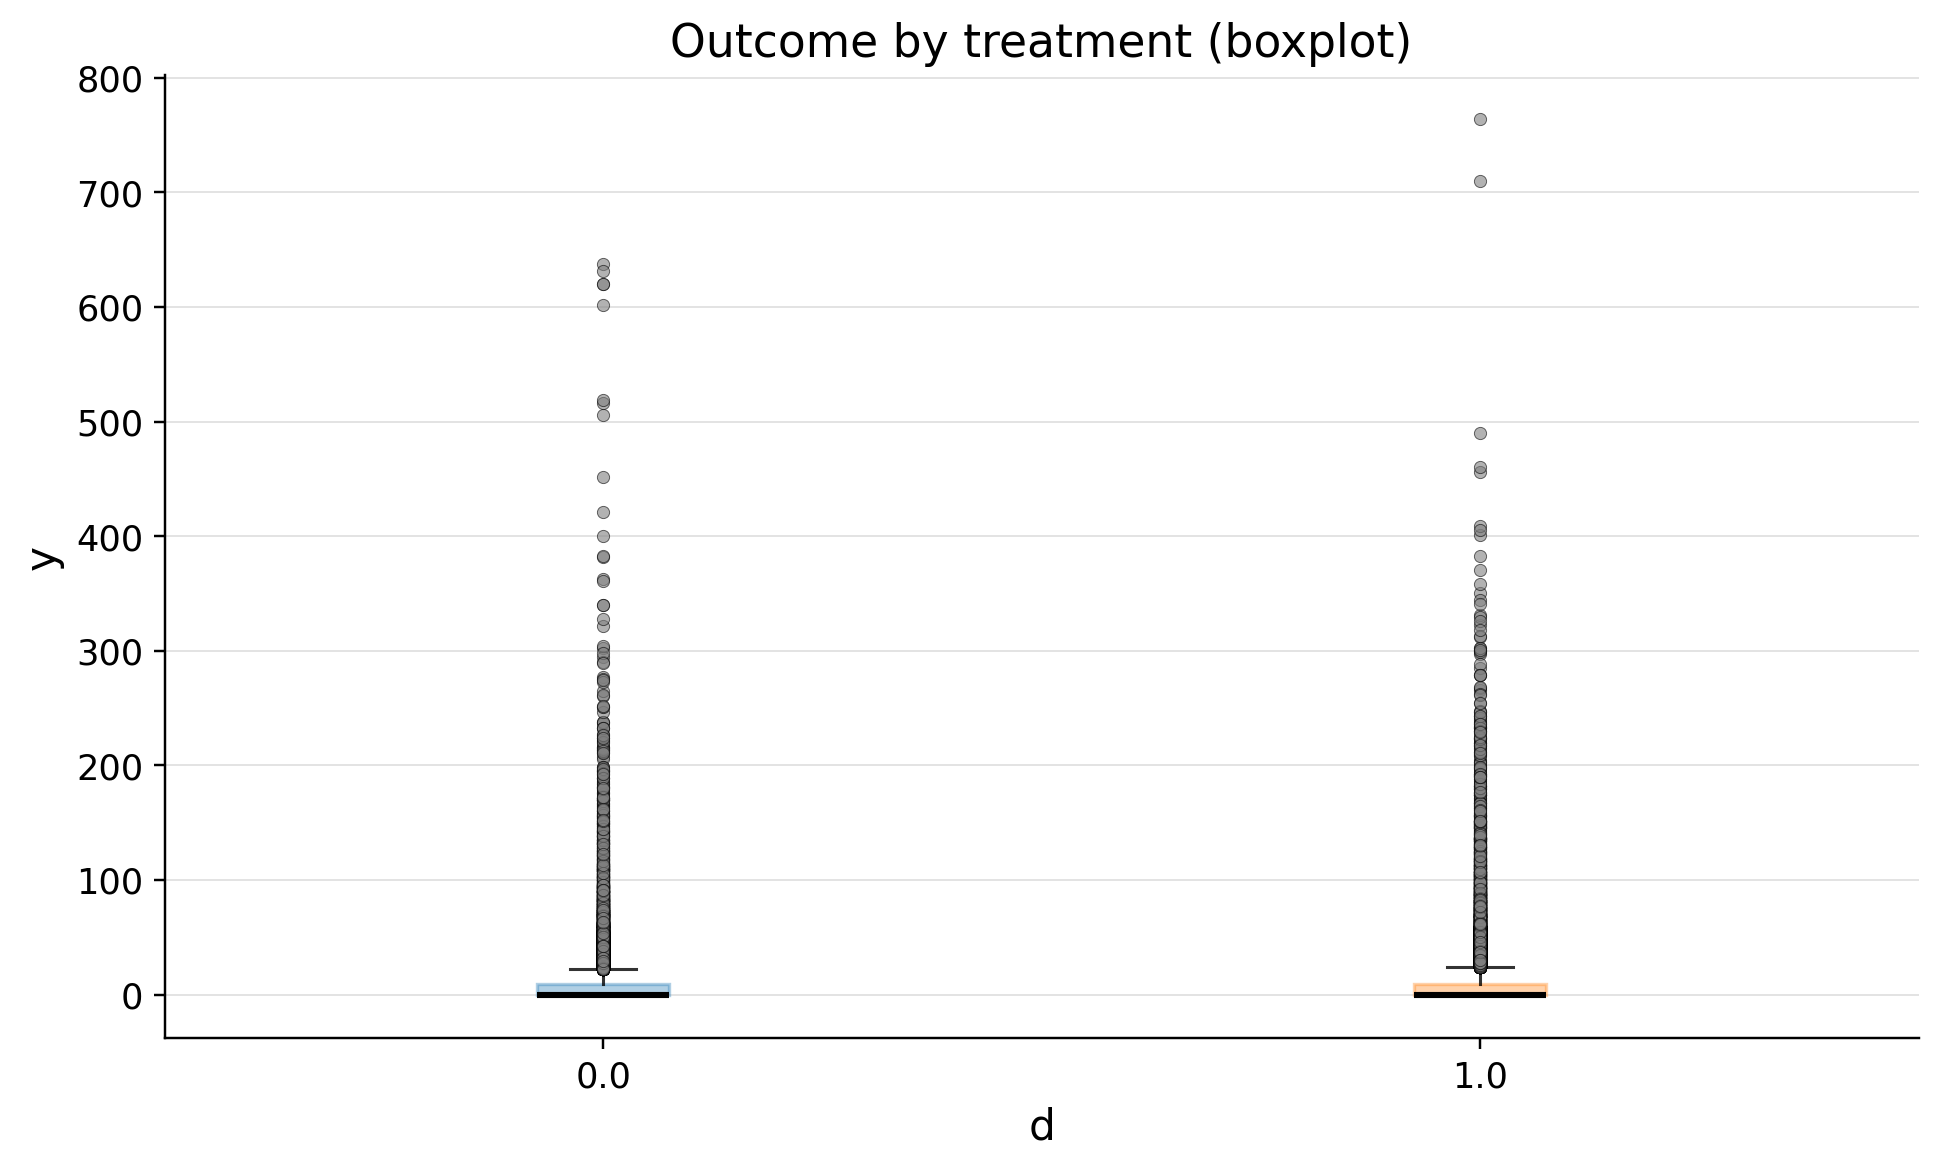

In [11]:
outcome_plot_boxplot(causaldata)